# **Final Project**

In [2]:
import warnings
warnings.filterwarnings('ignore')
import importlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json



'''
import os
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/lib/cuda'



# Ensure this runs before any TensorFlow operations
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print("here")
        print(e)
'''

import glob
import os
import shutil

2024-05-17 08:50:33.576314: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
'''Imports'''
#from src.preprocessing import preprocess
#from src.training import get_best_model
#from src.validation import Validator
#from src.prediction import Predictor
import src.objects.stack
importlib.reload(src.objects.stack)
from src.objects.stack import Stack

In [4]:
def remove_directories():
    # List of directories to remove within 'data'
    data_dirs = ['images', 'test', 'train', 'validation']
    base_data_path = 'data'

    # Directory within 'src/models'
    model_dir = 'unet_tuning'
    base_model_path = os.path.join('src', 'models', model_dir)

    # Removing directories in 'data'
    for dir_name in data_dirs:
        dir_path = os.path.join(base_data_path, dir_name)
        shutil.rmtree(dir_path, ignore_errors=True)

    # Removing 'unet_tuning' directory
    #shutil.rmtree(base_model_path, ignore_errors=True)
remove_directories()

## **Preprocessing and Augmentation**

In [5]:
'''Calls Preprocessing functions'''
import src.preprocess.preprocess_list as preprocessing
importlib.reload(preprocessing)

# Set the batch size according to your system's capabilities
BATCH_SIZE = 8
RESOLUTION = (480, 360)

# Call the preprocess function
stack = preprocessing.preprocess(BATCH_SIZE, RESOLUTION)

Current directory: /app/rundir/CPSC542_final_project
Current directory2: /app/rundir/CPSC542_final_project


100%|██████████| 1641/1641 [00:04<00:00, 386.91it/s]


## **Training**

In [7]:
'''Calls training functions'''
import src.training as training
importlib.reload(training)
import src.objects.architecture.conv_autoencoder as conv_autoencoder
importlib.reload(conv_autoencoder)


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

stack = training.get_best_model(stack)

Num GPUs Available:  1
Reloading Tuner from ./src/models/unet_tuning/tuner0.json
HEREHREHERHEHRHEHRHEHRHEHRHEHRH
range(0, 2)


2024-05-17 16:52:21.478508: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1637] Created device /device:GPU:0 with 78827 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:b7:00.0, compute capability: 8.0


here
here
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 480, 360, 1)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 480, 360, 64)      1664      
                                                                 
 batch_normalization_5 (Batc  (None, 480, 360, 64)     256       
 hNormalization)                                                 
                                                                 
 tf.nn.relu_5 (TFOpLambda)   (None, 480, 360, 64)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 240, 180, 64)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 240, 180, 128

In [8]:
import matplotlib.pyplot as plt
from skimage.color import rgb2lab,lab2rgb
import numpy as np

In [9]:
train_loss, train_accuracy = stack.final_model.evaluate(stack.bw_train_list, stack.train_list)
print(f"Accuracy on test data: {train_accuracy*100:.2f}%")

val_loss, val_accuracy = stack.final_model.evaluate(stack.bw_val_list, stack.val_list)
print(f"Accuracy on test data: {val_accuracy*100:.2f}%")

test_loss, test_accuracy = stack.final_model.evaluate(stack.bw_test_list, stack.test_list)
print(f"Accuracy on test data: {test_accuracy*100:.2f}%")

180/180 [==============================] - 19s 104ms/step - loss: 0.0180 - accuracy: 0.4211
Accuracy on test data: 42.11%
52/52 [==============================] - 5s 96ms/step - loss: 0.0179 - accuracy: 0.4337
Accuracy on test data: 43.37%
26/26 [==============================] - 4s 133ms/step - loss: 0.0186 - accuracy: 0.4357
Accuracy on test data: 43.57%


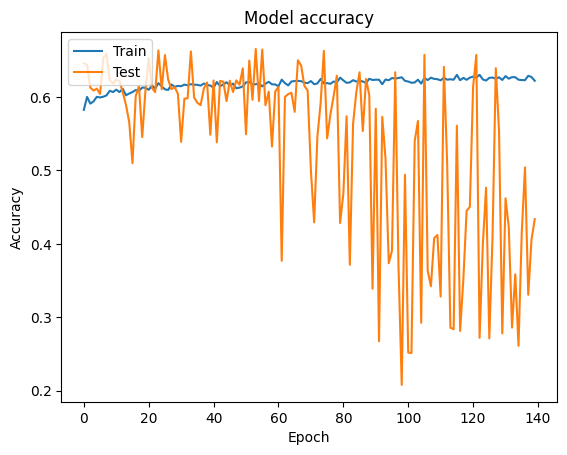

In [10]:
# Plot training & validation accuracy values
plt.plot(stack.final_history.history['accuracy'])
plt.plot(stack.final_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [11]:
predictions = stack.final_model.predict(stack.bw_test_list)
predictions.shape

26/26 [==============================] - 2s 90ms/step


(820, 480, 360, 3)

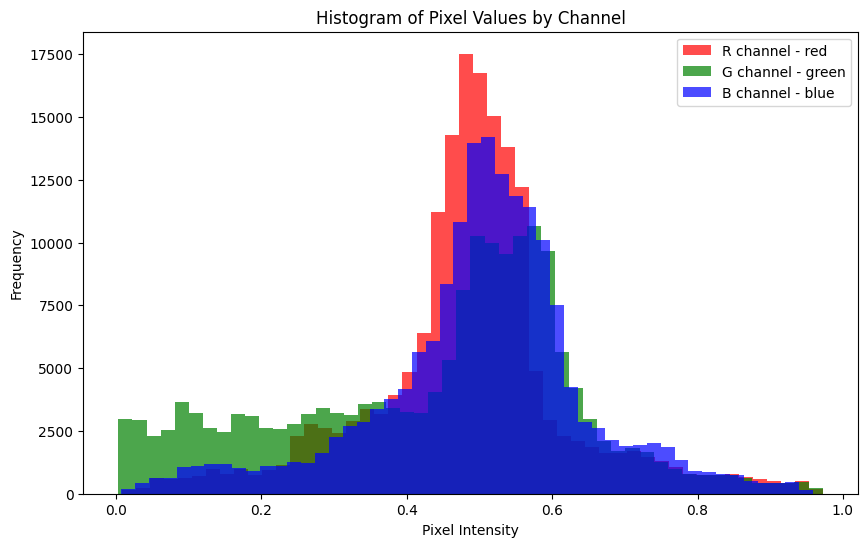

In [12]:
image = predictions[20]  # The first predicted image

# Create histograms for each color channel
colors = ('red', 'green', 'blue')
channel_labels = ('R channel', 'G channel', 'B channel')

plt.figure(figsize=(10, 6))
for i, color in enumerate(colors):
    channel = image[:, :, i].flatten()  # Extract channel and flatten
    plt.hist(channel, bins=50, color=color, alpha=0.7, label=f'{channel_labels[i]} - {color}')

plt.title('Histogram of Pixel Values by Channel')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.show()

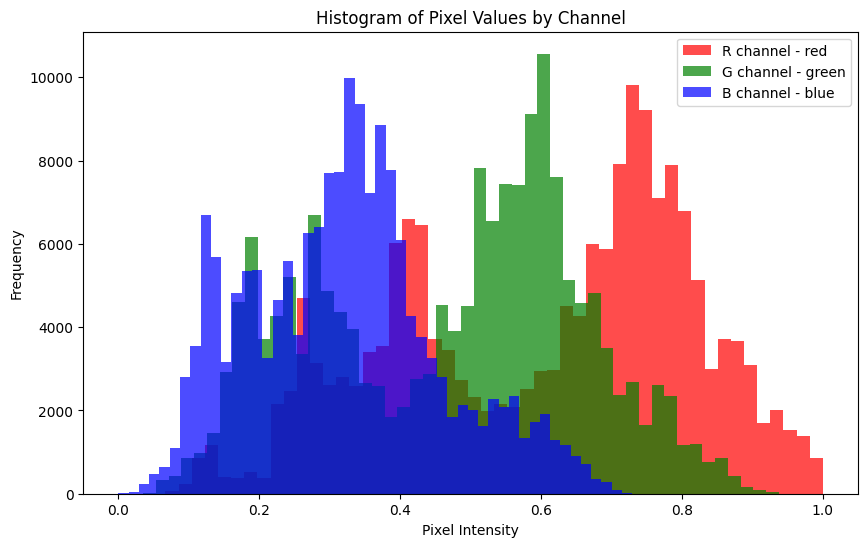

In [13]:
image = stack.test_list[20]  # The first predicted image


colors = ('red', 'green', 'blue')
channel_labels = ('R channel', 'G channel', 'B channel')

plt.figure(figsize=(10, 6))
for i, color in enumerate(colors):
    channel = image[:, :, i].flatten()  # Extract channel and flatten
    plt.hist(channel, bins=50, color=color, alpha=0.7, label=f'{channel_labels[i]} - {color}')

plt.title('Histogram of Pixel Values by Channel')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.show()

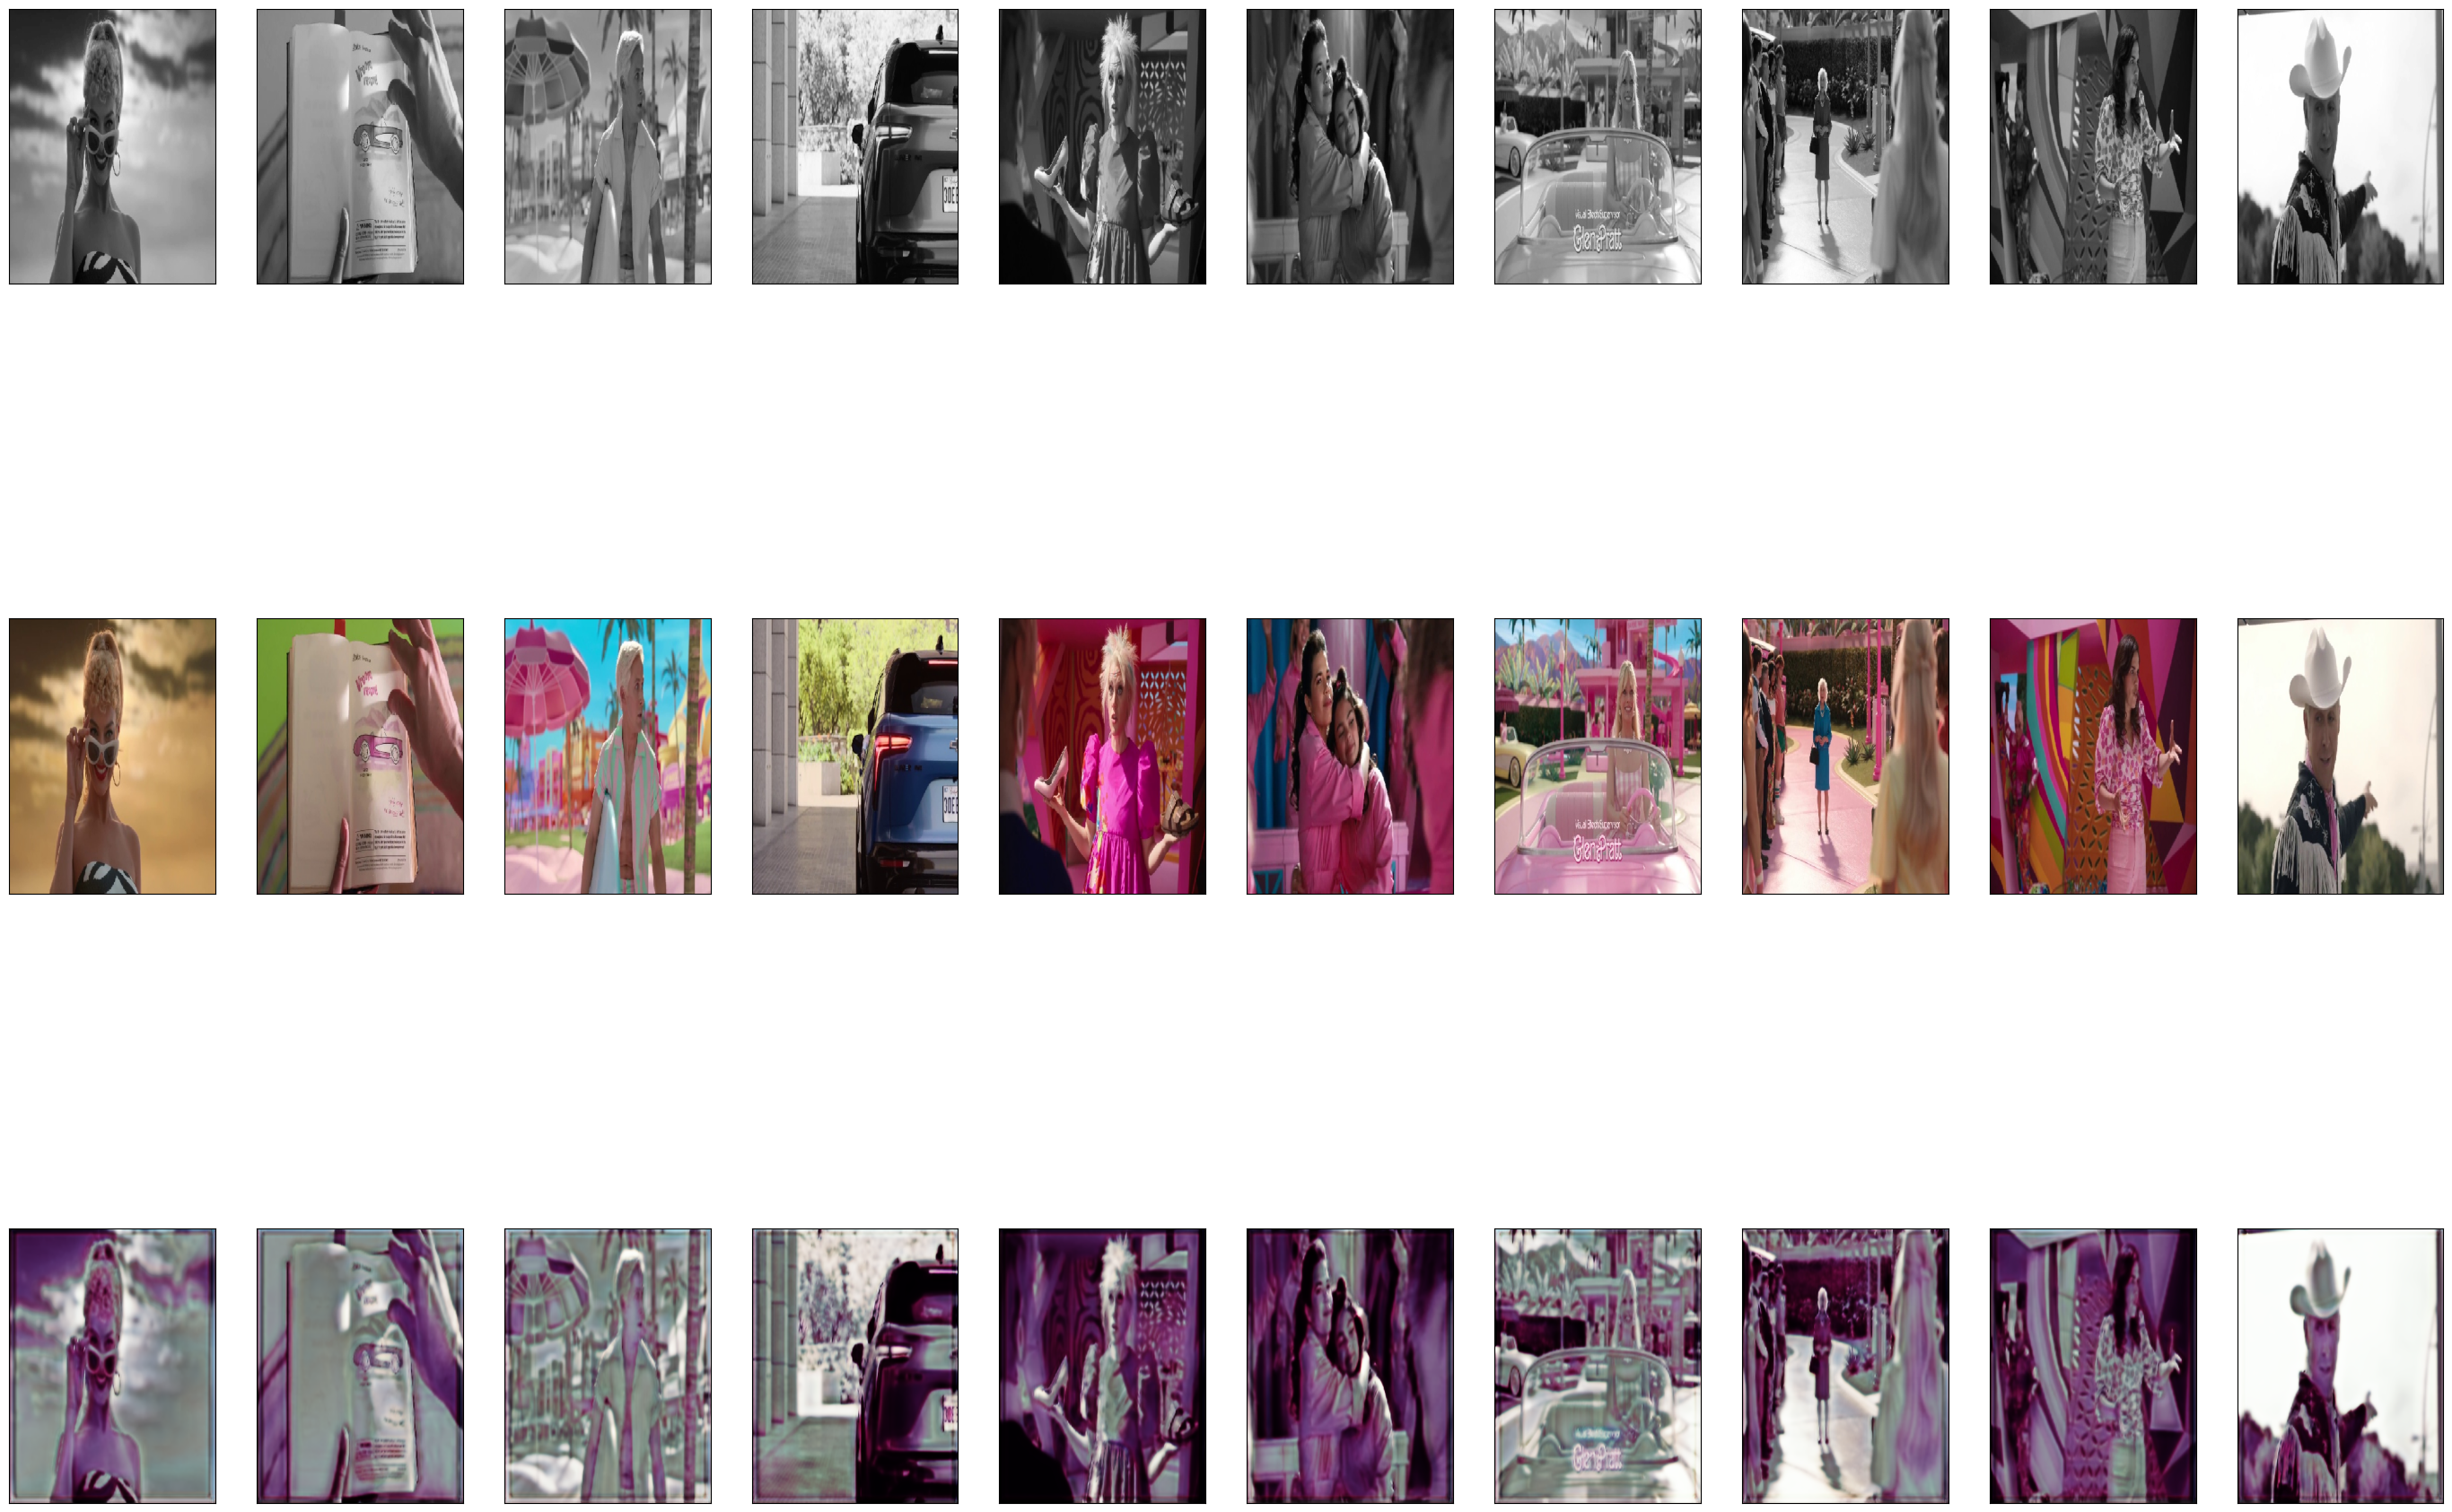

In [14]:





n = 10
plt.figure(figsize=(35, 25))
for i in range(n):
    show = 20+i*20
    # Display original gray images
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(stack.bw_test_list[show], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display original color images
    ax = plt.subplot(3, n, i + 1 + n)
    
    plt.imshow(stack.test_list[show])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display pred images
    ax = plt.subplot(3, n, i + 1 + 2*n)
    
    plt.imshow(predictions[show])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.savefig('result.png')

## **Prediction**

In [15]:
'''Calls prediction fucntions in prediction.py and methods from result'''
predictor = Predictor(model_path='path/to/saved/model')
input_data = 'path/to/input/data'
predictions = predictor.predict(input_data)

NameError: name 'Predictor' is not defined

## **Validation**

In [ ]:
'''Calls the validation fuctions in validation.py and methods from result'''
validator = Validator(model_path='path/to/saved/model')
validation_data = 'path/to/validation/data'
evaluation_metrics = validator.validate(validation_data)